<h1 style="color:rgb(0,120,170)">Autoencoder </h1>
<h2 style="color:rgb(0,120,170)">OEAW Machine Learning Summer School 2019</h2>

Vanilla implementation of an autoencoder.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
from torchvision.utils import save_image
import matplotlib
import matplotlib.pyplot as plt
import os

In [3]:
# Hyperparameters
args = SimpleNamespace(batch_size=64, test_batch_size=64, epochs=2,
                       lr=0.001, momentum=0.5, seed=1, log_interval=100,
                      weight_decay = 1e-5)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [4]:
# Data loader (downloads data automatically the first time)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join('.','..','data'), train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join('.','..','data'), train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

if not os.path.exists(os.path.join('.','samples')):
    os.makedirs(os.path.join('.','samples'))

torch.Size([60000])
torch.Size([60000, 28, 28])
Input dimension is 784.


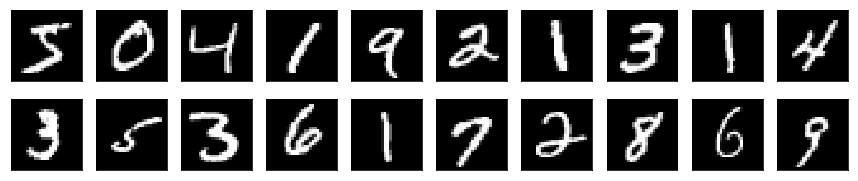

In [6]:
print(train_loader.dataset.targets.shape)
print(train_loader.dataset.data.shape)
input_dim = train_loader.dataset.data.shape[1]*train_loader.dataset.data.shape[2]
print("Input dimension is {}.".format(input_dim))

# Plot example images
fig=plt.figure(figsize=(15,3))
for image in range(20):
    show_img = train_loader.dataset.data[image].numpy().reshape(28, 28)
    fig.add_subplot(2,10,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(show_img, cmap='gray')
plt.show()

In [7]:
class autoencoder(nn.Module):
    def __init__(self, ae_input_dim):
        super(autoencoder, self).__init__()
        # encoder
        self.encoder_linear1 = nn.Linear(ae_input_dim, 256)
        self.encoder_linear2 = nn.Linear(256, 64)
        # decoder
        self.decoder_linear1 = nn.Linear(64,256)
        self.decoder_linear2 = nn.Linear(256, ae_input_dim)
        
    def encoder(self, x):
        x = self.encoder_linear1(x)
        x = F.relu(x)
        x = self.encoder_linear2(x)
        x = F.relu(x)
        return x
    
    def decoder(self, x):
        x = self.decoder_linear1(x)
        x = F.relu(x)
        x = self.decoder_linear2(x)
        x = torch.sigmoid(x)
        return x
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
# This function trains the model for one epoch
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim)
        data = data.to(device)
        output = model(data)
        loss = criterion(output, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
            with torch.no_grad():
                x = data.view(-1,1,28,28)
                x = x.cpu()
                x_hat = output.view(-1,1,28,28)
                x_hat = x_hat.cpu()
                save_image(x, os.path.join('.','samples','x_{}.png'.format(epoch)))
                save_image(x_hat, os.path.join('.','samples','x_hat_{}.png'.format(epoch)))

In [12]:
# This function evaluates the model on the test data
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, input_dim)
            data = data.to(device)
            output = model(data)
            test_loss += torch.sum(criterion(output, data)).item() # sum up batch loss
    test_loss /= len(test_loader.dataset)
    test_loss *= args.test_batch_size
    print('\nTest set loss: {:.4f}'.format(test_loss))

In [13]:
model = autoencoder(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)
    
print("Done")

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.693626
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.248450
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.180868
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.154358
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.141085
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.135599
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.134921
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.130384
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.125264
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.117751

Test set loss: 0.1129
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.116935
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.109701
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.112804
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.105076
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.104262
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.110190
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.101896
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.098935
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.099092
Train Epoch: 2 [57600/60000 (96%)]	Loss